In [131]:
# #ephemeris sim
# using LinearAlgebra
# #make sure to cite this package
# using SPICE
# using Downloads: download 
# using DifferentialEquations
# using Plots

In [132]:
using DifferentialEquations
using LinearAlgebra
using Plots
using SPICE

In [133]:
# using Pkg
# Pkg.activate()

In [134]:
using DelimitedFiles
xtraj  = readdlm("xtraj.txt", '\t', Float64, '\n')

#in days
time_steps = readdlm("time.txt", '\t', Float64, '\n')
#period 

T_periodic_n = 3.414975410587678

3.414975410587678

In [135]:
xtraj

6×131 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …      4.3125e5      4.3125e5
     0.0           2.11866        4.21631        -974.27         -0.00385146
  2286.77       2286.77        2286.77           2285.38       2286.77
     0.0           0.0301068      0.0599152       -13.9354        0.00219923
 15649.0       15649.0        15649.0           15640.9       15649.0
     0.0          -0.0967975     -0.192635   …     44.5037        0.000129386

In [136]:
# Load leap seconds kernel
furnsh("/home/faustovega/Desktop/astrodynamics_nasa_work/naif0012.tls")

# laptop 
# furnsh("/home/fausto/naif0012.tls")

In [137]:
# Convert the calendar date to ephemeris seconds past J2000

#was 2018
#et = utc2et("2018-02-06T20:45:00")


#et = utc2et("2000-08-06T20:45:00")

et = 0

0

In [138]:
# Load a planetary ephemeris kernel
furnsh("/home/faustovega/Desktop/astrodynamics_nasa_work/de440.bsp")

#laptop
# furnsh("/home/fausto/de440.bsp")

In [139]:
#gravitational parameters for the bodies (km3/s2)

#moon 
# μ_m = 4902.80058214776

# #earth
# μ_e = 398600.432896939

# #sun
# μ_s = 132712440017.987

In [140]:
#units used to normalize
#also in km and seconds

#distance
# l_star = 385692.50

# #time
# t_star = 377084.152667038

# #in km
# lunar_radius = 1738.2 

In [141]:
# μ_earth_moon = 1.215058560962404E-2

In [142]:
G = 6.67430e-11/(1000)^3 #units: km3/kg s2 
earth_mass = 5.97219e24
moon_mass = 7.34767309e22
μ_gm = G*(earth_mass+moon_mass)

403505.9346204587

In [143]:
μ_e = 3.986004415000000e5
μ_m = 4.902800582147800e3

#from paper
# l_star = 3.84400e5

# μ_earth_moon = 1.215058535056245e-2

# t_star = 3.751902588926273e5

4902.8005821478

In [144]:
#from the cr3bp book
l_star = 3.850e5

μ_earth_moon = 1.215e-2

T_ = 2.361e6

t_star = T_/2*pi

3.7086501275627506e6

In [145]:
sqrt(μ_gm/l_star^3)

2.6590950955684876e-6

In [146]:
pose_m1 = [-μ_earth_moon*l_star , 0, 0]

3-element Vector{Float64}:
 -4677.75
     0.0
     0.0

In [147]:
function hat(x)

    ω_hat = [0 -x[3] x[2]; x[3] 0 -x[1]; -x[2] x[1] 0]

    return ω_hat
    
end

hat (generic function with 1 method)

In [148]:
#get the ECI state given a state in the rotating coordinate frame 
#all in km and s
function cr3bp_to_ephem(x_r, time)

    #state in the ECI ra
    x_eci = zeros(6)

    #time is already wrt et
    
    #state of the moon (position and velocity) relative to Earth (in km and km/s)
    moon_state = spkezr("moon",time,"J2000","NONE","earth")[1]

    #position of the moon relative to Earth
    r_moon = moon_state[1:3]

    #velocity of the moon relative to Earth
    v_moon = moon_state[4:6]

    #x component of the rotating frame expressed in inertial coordinates
    x̃ = r_moon/norm(r_moon)
    #z component of the rotating frame expressed in inertial coordinates
    z̃ = cross(r_moon, v_moon)/norm(cross(r_moon, v_moon))
    #x component of the rotating frame expressed in inertial coordinates
    ỹ = cross(z̃, x̃)

    #instantanous rotation matrix from rotating frame to inertial frame (centered at Earth)
    eci_R_r = [x̃ ỹ z̃]

    #cr3bp assumes that the rotating frame is rotating by the mean motion 

    #mean motion θ_dot
    #θ_dot = 2*pi/2.361e6

    #θ_dot = sqrt(μ_earth_moon/norm(r_moon)^3)

    θ_dot = sqrt(μ_gm/norm(l_star)^3)

    #θ_dot = sqrt(μ_gm/norm(r_moon)^3)

    #instantanous angular velocity
    #θ_dot = norm(cross(r_moon, v_moon))/(norm(r_moon)^2)
    #θ_dot = (cross(r_moon, v_moon)/(norm(r_moon)^2))[3]

    #println("theta dot 2: ", θ_dot_2)

    ω = [0, 0, θ_dot]
    ω_hat= hat(ω)
    
    #position transformation
    x_eci[1:3] = eci_R_r*(x_r[1:3] - pose_m1)

    x_eci[4:6] = eci_R_r*x_r[4:6] + eci_R_r*ω_hat*(x_r[1:3] - pose_m1)

    return x_eci
end

cr3bp_to_ephem (generic function with 1 method)

In [149]:
#get the ECI state given a state in the rotating coordinate frame 
#all in km and s
function cr3bp_to_ephem_k(x_r, time)

    #state in the ECI ra
    x_eci = zeros(6)

    #time is already wrt et
    
    #state of the moon (position and velocity) relative to Earth (in km and km/s)
    bary_state = spkezr("earth_barycenter",time,"J2000","NONE","earth")[1]

    #position of the moon relative to Earth
    r_bary = bary_state[1:3]

    #velocity of the moon relative to Earth
    v_bary = bary_state[4:6]

    θ_dot = sqrt(μ_gm/norm(l_star)^3)

    ω = [0, 0, θ_dot]

    ω_hat= hat(ω)
    
    #position transformation
    x_eci[1:3] = r_bary + x_r[1:3]

    x_eci[4:6] = v_bary + (x_r[4:6] - v_bary) + cross(ω, (x_eci[1:3] - r_bary))

    return x_eci
end

cr3bp_to_ephem_k (generic function with 1 method)

In [150]:
#get the ECI state given a state in the rotating coordinate frame 
#all in km and s
function ephem_to_cr3bp_k(x_eci, time)

    #state in the ECI ra
    x_r = zeros(6)

    #time is already wrt et
    
    #state of the moon (position and velocity) relative to Earth (in km and km/s)
    bary_state = spkezr("earth_barycenter",time,"J2000","NONE","earth")[1]

    #position of the moon relative to Earth
    r_bary = bary_state[1:3]

    #velocity of the moon relative to Earth
    v_bary = bary_state[4:6]

    θ_dot = sqrt(μ_gm/norm(l_star)^3)

    ω = [0, 0, θ_dot]

    ω_hat= hat(ω)
    
    #position transformation
    x_r[1:3] = x_eci[1:3] - r_bary 

    x_r[4:6] = x_eci[4:6] - cross(ω, (x_eci[1:3] - r_bary)) 
    
    return x_eci
end

ephem_to_cr3bp_k (generic function with 1 method)

In [151]:
#get the ECI state given a state in the rotating coordinate frame 
#all in km and s
function cr3bp_to_ephem_k2(x_r, time)

    #state in the ECI ra
    x_eci = zeros(6)

    #time is already wrt et
    
    #state of the moon (position and velocity) relative to Earth (in km and km/s)
    bary_state = spkezr("earth_barycenter",time,"J2000","NONE","earth")[1]

    #position of the moon relative to Earth
    r_bary = bary_state[1:3]

    #velocity of the moon relative to Earth
    v_bary = bary_state[4:6]

    #x component of the rotating frame expressed in inertial coordinates
    x̃ = r_bary/norm(r_bary)
    #z component of the rotating frame expressed in inertial coordinates
    z̃ = cross(r_bary, v_bary)/norm(cross(r_bary, v_bary))
    #x component of the rotating frame expressed in inertial coordinates
    ỹ = cross(z̃, x̃)
 
    #instantanous rotation matrix from rotating frame to inertial frame (centered at Earth)
    eci_R_r = [x̃ ỹ z̃]

    θ_dot = sqrt(μ_gm/norm(l_star)^3)

    ω = [0, 0, θ_dot]

    ω_hat= hat(ω)
    
    #position transformation
    x_eci[1:3] = r_bary + eci_R_r*x_r[1:3]

    x_eci[4:6] = v_bary + (eci_R_r*ω_hat*x_r[1:3] + eci_R_r*x_r[4:6])

    return x_eci
end

cr3bp_to_ephem_k2 (generic function with 1 method)

In [152]:
#get the ECI state given a state in the rotating coordinate frame 
#all in km and s
function ephem_to_cr3bp_k2(x_eci, time)

    #state in the ECI ra
    x_r = zeros(6)

    #time is already wrt et
    
    #state of the moon (position and velocity) relative to Earth (in km and km/s)
    bary_state = spkezr("earth_barycenter",time,"J2000","NONE","earth")[1]

    #position of the moon relative to Earth
    r_bary = bary_state[1:3]

    #velocity of the moon relative to Earth
    v_bary = bary_state[4:6]

    #x component of the rotating frame expressed in inertial coordinates
    x̃ = r_bary/norm(r_bary)
    #z component of the rotating frame expressed in inertial coordinates
    z̃ = cross(r_bary, v_bary)/norm(cross(r_bary, v_bary))
    #x component of the rotating frame expressed in inertial coordinates
    ỹ = cross(z̃, x̃)
 
    #instantanous rotation matrix from rotating frame to inertial frame (centered at Earth)
    eci_R_r = [x̃ ỹ z̃]

    θ_dot = sqrt(μ_gm/norm(l_star)^3)

    ω = [0, 0, θ_dot]

    ω_hat= hat(ω)
    
    #position transformation
    x_r[1:3] = x_eci[1:3] - r_bary 

    x_r[4:6] = x_eci[4:6] - cross(ω, (x_eci[1:3] - r_bary)) 
    
    return x_eci
end

ephem_to_cr3bp_k2 (generic function with 1 method)

In [153]:
#get the ECI state given a state in the rotating coordinate frame 
#all in km and s
function ephem_to_cr3bp(x_eci, time)

    #state in the ECI ra
    x_r = zeros(6)

    #time is already wrt et
    
    #state of the moon (position and velocity) relative to Earth (in km and km/s)
    moon_state = spkezr("moon",time,"J2000","NONE","earth")[1]

    #position of the moon relative to Earth
    r_moon = moon_state[1:3]

    #velocity of the moon relative to Earth
    v_moon = moon_state[4:6]

    #x component of the rotating frame expressed in inertial coordinates
    x̃ = r_moon/norm(r_moon)
    #z component of the rotating frame expressed in inertial coordinates
    z̃ = cross(r_moon, v_moon)/norm(cross(r_moon, v_moon))
    #x component of the rotating frame expressed in inertial coordinates
    ỹ = cross(z̃, x̃)

    #instantanous rotation matrix from rotating frame to inertial frame (centered at Earth)
    eci_R_r = [x̃ ỹ z̃]

    r_R_eci = inv(eci_R_r) #also the transpose since it is a rotation matrix

    #cr3bp assumes that the rotating frame is rotating by the mean motion 

    #θ_dot = 2*pi/2.361e6

    #θ_dot = sqrt(μ_earth_moon/norm(r_moon)^3)

    θ_dot = sqrt(μ_gm/norm(l_star)^3)

    #θ_dot = sqrt(μ_gm/norm(r_moon)^3)

    #instantanous angular velocity
    #θ_dot = norm(cross(r_moon, v_moon))/(norm(r_moon)^2)
    #θ_dot_2 = (cross(r_moon, v_moon)/(norm(r_moon)^2))[3]

    #println("theta dot 2: ", θ_dot_2)

    ω = [0, 0, θ_dot]

    ω_hat= hat(ω)
    
    #position transformation
    x_r[1:3] = (r_R_eci*x_eci[1:3]) + pose_m1

    x_r[4:6] =  r_R_eci*(x_eci[4:6] - eci_R_r*ω_hat*(x_r[1:3] - pose_m1))

    return x_r
end

ephem_to_cr3bp (generic function with 1 method)

In [154]:
test = [431249.946141646,
0.0,
2286.769716989665,
0.0,
0.1811228748758214,
0.0]

6-element Vector{Float64}:
 431249.946141646
      0.0
   2286.769716989665
      0.0
      0.1811228748758214
      0.0

In [187]:
bary_state = spkezr("earth_barycenter",0,"J2000","NONE","earth")[1]

#position of the moon relative to Earth
r_bary = bary_state[1:3]

3-element Vector{Float64}:
 -3543.2122880199777
 -3240.7653939449465
  -924.6896922398622

In [155]:
#this matches the pavlack paper
ephem_sim = cr3bp_to_ephem(test, et)

6-element Vector{Float64}:
 -315693.58262988477
 -289703.3640967419
  -80297.62323033324
       0.9181147361482338
      -0.8878048413691402
      -0.4065236279818293

In [156]:
#this matches the pavlack paper
ephem_sim = cr3bp_to_ephem_k(test, et)

6-element Vector{Float64}:
 427706.733853626
  -3240.7653939449465
   1362.0800247498028
      0.0
      1.3278574916252466
      0.0

In [157]:
ephem_sim = cr3bp_to_ephem_k2(test, et)

6-element Vector{Float64}:
 -315847.3658429277
 -289844.0204487997
  -80337.75679851409
       0.9174134791832707
      -0.8876589467596865
      -0.4064121796678801

In [158]:
# barypose = spkezr("earth_barycenter",0,"J2000","NONE","earth")[1]

# moonpose = spkezr("moon",0,"J2000","NONE","earth")[1]

In [159]:
# barypose[4:6]/norm(barypose[4:6])

In [160]:
# moonpose[4:6]/norm(moonpose[4:6])

In [161]:
# barypose[1:3]/norm(barypose[1:3])

In [162]:
moonpose[1:3]/norm(moonpose)

3-element Vector{Float64}:
 -0.7245853401671889
 -0.6627350845765673
 -0.1890986316191438

In [163]:
# scatter([0], [0], [0])
# scatter!([barypose[1]], [barypose[2]], [barypose[3]])
# scatter!([moonpose[1]], [moonpose[2]], [moonpose[3]])

In [164]:
# norm(barypose[1:3])

In [165]:
# 1.215e-2*3.850e5 

In [166]:
# l_star 

In [167]:
# μ_earth_moon*l_star 

In [168]:
ephem_sim_dimensionalized = [ephem_sim[1:3]/l_star; ephem_sim[4:6]/(l_star/t_star)]

6-element Vector{Float64}:
 -0.8203827684231889
 -0.7528416115553239
 -0.20866949817795868
  8.83731328987227
 -8.550692119824749
 -3.9149106025151665

In [169]:
function just_dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ephem_dynamics!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-15, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate (generic function with 1 method)

In [170]:
function just_dynamics_integrate_scaled(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ephem_dynamics_scaled!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-15, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate_scaled (generic function with 1 method)

In [171]:
function ephemeris_model_EarthMoon(x, t)

    xdot = zeros(6)

    xdot[1:3] = x[4:6]

    #position of the spacecraft relative to the earth 
    r_qi = x[1:3]

    time = et + t

    #get positions of moon and sun relative to earth 
    rqj_moon = spkpos("moon", time, "J2000", "none", "earth")[1]
    
    rij_moon = rqj_moon- r_qi 

    #r_qi - vector that defines the position of the satellite wrt Earth
    #rqj is the position of a planetary body wrt satellite

    #just Earth and Moon
    xdot[4:6] = (-μ_e/(norm(r_qi))^3)*r_qi + μ_m.*((rij_moon/norm(rij_moon)^3)-(rqj_moon/norm(rqj_moon)^3));


    return xdot

end

ephemeris_model_EarthMoon (generic function with 1 method)

In [172]:
function ephemeris_model_EarthMoon_scaled(x, t)

    #put units on x and t

    x_units = [x[1:3]*l_star; x[4:6]*(l_star/t_star)]
    t_units = t*t_star

    xdot = zeros(6)

    xdot[1:3] = x[4:6]

    #position of the spacecraft relative to the earth. normalized
    r_qi = x_units[1:3]

    time = et + t_units

    #get positions of moon and sun relative to earth. dimensionalized by l_star

    rqj_moon = (spkpos("moon", time, "J2000", "none", "earth")[1])

    rij_moon = rqj_moon- r_qi 

    #r_qi - vector that defines the position of the satellite wrt Earth
    #rqj is the position of a planetary body wrt satellite

    #just Earth and Moon
    xdot_dim = (-μ_e/(norm(r_qi))^3)*r_qi + μ_m.*((rij_moon/norm(rij_moon)^3)-(rqj_moon/norm(rqj_moon)^3));

    xdot[4:6] = xdot_dim./(l_star/t_star^2)

    
    return xdot

end

ephemeris_model_EarthMoon_scaled (generic function with 1 method)

In [173]:
function ephem_dynamics!(du, u, p, t)
    
    #dependence on time
    du[1:6] = ephemeris_model_EarthMoon(u[1:6], t)
    
end

ephem_dynamics! (generic function with 1 method)

In [174]:
function ephem_dynamics_scaled!(du, u, p, t)
    
    #dependence on time
    du[1:6] = ephemeris_model_EarthMoon_scaled(u[1:6], t)
    
end

ephem_dynamics_scaled! (generic function with 1 method)

In [175]:
time_steps_s = time_steps*86400

131×1 Matrix{Float64}:
   0.0
  11.697359139965018
  23.27874742489753
  37.184103746805235
  59.0195302877028
  82.00807239391601
 110.33890232618462
 139.16053995286458
 171.75197949393433
 211.33393177580447
   ⋮
   1.1989630166289548e6
   1.2107651091746096e6
   1.2223891936145483e6
   1.2340062417344307e6
   1.2453673276059336e6
   1.2565472951957565e6
   1.267261519310328e6
   1.277847659736725e6
   1.2832276226493693e6

In [176]:
sol_scaled = just_dynamics_integrate_scaled(ephem_sim_dimensionalized, time_steps_s[end]/t_star)

retcode: Success
Interpolation: 3rd order Hermite
t: 218-element Vector{Float64}:
 0.0
 0.0031601846571807208
 0.005025172043310566
 0.007468013599506877
 0.009615626994330847
 0.011909067278090319
 0.01413028844798768
 0.016385712005931433
 0.01861974573530741
 0.020859159487847532
 ⋮
 0.3296710340180899
 0.3316010922260872
 0.3336407668109511
 0.3357981928511851
 0.33808484598482647
 0.3404992699816791
 0.3430423170860831
 0.3457319267100418
 0.346009350710222
u: 218-element Vector{Vector{Float64}}:
 [-0.8203827684231889, -0.7528416115553239, -0.20866949817795868, 8.83731328987227, -8.550692119824749, -3.9149106025151665]
 [-0.7916525380265, -0.7790580540228594, -0.22086348183768814, 9.337867482349049, -8.032274366632706, -3.7986124454508197]
 [-0.7739801580556592, -0.7937331377487029, -0.2278752456356196, 9.610901730713532, -7.702314248800107, -3.7194566656755894]
 [-0.7500933401302163, -0.8119956243679446, -0.23682301484319376, 9.940035574894162, -7.24492214225355, -3.6040462412696

In [177]:
sol = just_dynamics_integrate(ephem_sim, time_steps_s[end])

retcode: Success
Interpolation: 3rd order Hermite
t: 235-element Vector{Float64}:
   0.0
   0.08397952002145812
   0.3702921507321265
   1.256499127921785
   3.643574702391465
   9.977790812186898
  25.250778918042556
  56.27441263166308
 120.535367022738
 244.44561206326438
   ⋮
   1.2188938103654827e6
   1.2258243489718619e6
   1.2331775813037138e6
   1.2409220168421483e6
   1.249137156701412e6
   1.2578187004615436e6
   1.2669741455642476e6
   1.2766654697804798e6
   1.2832276226493693e6
u: 235-element Vector{Vector{Float64}}:
 [-315847.3658429277, -289844.0204487997, -80337.75679851409, 0.9174134791832707, -0.8876589467596865, -0.4064121796678801]
 [-315847.2887989678, -289844.0949939566, -80337.79092881059, 0.9174138676313891, -0.8876585808478399, -0.40641210148820783]
 [-315847.0261316003, -289844.34914164146, -80337.90728969037, 0.9174151919717306, -0.8876573333369584, -0.40641183494819033]
 [-315846.2131100399, -289845.13578805263, -80338.26745432854, 0.9174192911101021, -0.887

In [178]:
#this just tests one timestep
#sol = just_dynamics_integrate(ephem_sim, time_steps_s[2])

In [179]:
function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [180]:
all_states_scaled = get_state(sol_scaled)

all_states = get_state(sol)

6×235 Matrix{Float64}:
      -3.15847e5      -3.15847e5  …      2.12397e5      2.07239e5
 -289844.0            -2.89844e5         2.391e5        2.4132e5
  -80337.8        -80337.8           75016.6        76272.6
       0.917413        0.917414         -0.785367      -0.786812
      -0.887659       -0.887659          0.342655       0.33413
      -0.406412       -0.406412   …      0.193667       0.189143

In [181]:
all_states_scaled[:,end]

6-element Vector{Float64}:
  0.5382837484917514
  0.6268062228145174
  0.1981105994329638
 -7.579243758205968
  3.218627259959489
  1.8219889734769135

In [182]:
[all_states_scaled[1:3,end]*l_star; all_states_scaled[4:6,end]*(l_star/t_star)]

6-element Vector{Float64}:
 207239.2431693243
 241320.3957835892
  76272.58078169107
     -0.7868115747081684
      0.3341300614676105
      0.18914314660617518

In [183]:
#scaled and unscaled give the same answer
all_states[:,end]

6-element Vector{Float64}:
 207239.24316931717
 241320.39578360878
  76272.580781699
     -0.786811574708201
      0.3341300614674473
      0.18914314660613876

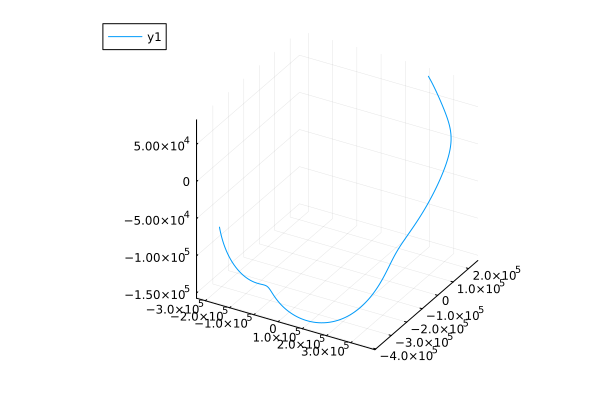

In [184]:
plot(all_states[1,:], all_states[2,:], all_states[3,:])

#plot!(xtraj[1,:], xtraj[2,:], xtraj[3,:])

In [185]:
#transfer all to cr3bp 
all_states_cr3bp = zeros(size(all_states))

for i=1:size(all_states)[2]

    all_states_cr3bp[:,i] = ephem_to_cr3bp(all_states[:,i], et+sol.t[i])

end

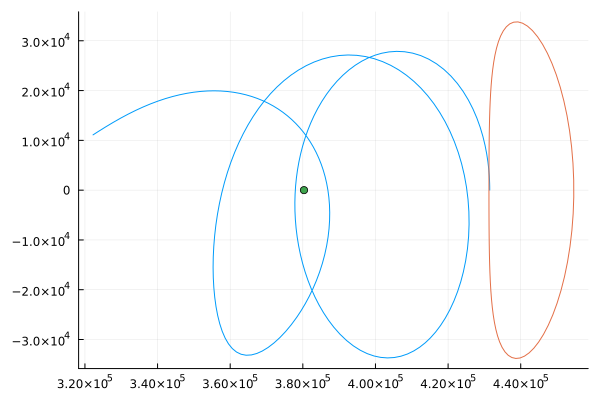

In [186]:
# plot(all_states_cr3bp[1,:], all_states_cr3bp[2,:], all_states_cr3bp[3,:])

# plot!(xtraj[1,1:7], xtraj[2,1:7], xtraj[3,1:7])

test = plot(all_states_cr3bp[1,:], all_states_cr3bp[2,:], label = "Ephemeris Forward Rollout")

plot!(xtraj[1,:], xtraj[2,:], label = "original cr3bp orbit") 

scatter!([(1-μ_earth_moon)*l_star], [0], label = "Moon", legend=false) 



#scatter!([all_states_cr3bp[1,1]], [all_states_cr3bp[2,1]], [all_states_cr3bp[3,1]])

In [ ]:
savefig(test, "traj Plots")

In [ ]:
plot(all_states_cr3bp[1,1:5], all_states_cr3bp[2,1:5], label = "Ephemeris Forward Rollout")

plot!(xtraj[1,1:2], xtraj[2,1:2], label = "original cr3bp orbit") 

In [ ]:
# all_states[:,end]

In [ ]:
# ephem_to_cr3bp(all_states[:,end], time_steps_s[2])

In [ ]:
# ephem_to_cr3bp(all_states[:,1], 0)

In [ ]:
# scatter([all_states[1,2]], [all_states[2,2]], [all_states[3,2]])
# scatter!([check[1]], [check[2]], [check[3]])

In [ ]:
# #convert the ephemeris back to cr3bp

# for i = 1:size(all_states)[2]
#     all_states[:,i] = cr3bp_to_ephem(all_states[:,i], time_steps_s[i])
# end

In [ ]:
#tried one timestep and it is in the correct direction. (this is with the regular km s dynamics) Maybe
#do the same test with the scaled dynamics (just one step) and see if it works. Get x traj at fixed time_steps
#steps (the 41 knot points) and compare to that. 

#verify the angular velocity term



#Maybe period of integration is wrong. 
#and may work better with just fixed defined timesteps